# Conditional stalling for Zipf distributed addresses

## Publication
This work has an associated publication:

Title: "Boosting performance of HLS dataflows with datadependencies using fast conditional stalling"

Authors: Tobías Alonso, Gustavo Sutter, Sergio Lopez-Buedo, and Jorge E. López de Vergara

In [ ]:
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.stats import binom
from conditional_stalling import *

In [2]:
colors = ['k','b','c','g','y','m','r']
markers = [ '.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
import matplotlib
font = {'family':'serif','weight':'normal','size':10}
matplotlib.rc('font', **font)

In [3]:
# %matplotlib qt
np.random.seed(0)

# Zipf source generator

In [4]:
k=1
s=1.8
N=8
zipf_prob(k,s,N)

0.6035740271719456

## Show distribution

In [5]:
def test_zipf_generator(N=32):
  samples = 100000
  plt.figure()
  plt.grid(True)
  
  plt.xlabel("X")
  plt.ylabel("P(X)")
  for s in np.arange(.2,2,.4):
    hist = [0 for i in range(N)]
    CDF = zipf_CDF(s,N)
    for i in tqdm(range(samples)):
      hist[rand_CDF(CDF)] +=1

    plt.plot(range(N),np.array(hist)/samples,"*-.",label="s=%f" % s)
  plt.legend()

100%|██████████| 100000/100000 [00:00<00:00, 1010909.51it/s]


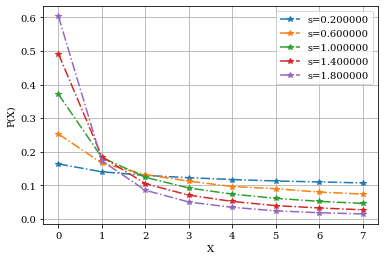

In [6]:
test_zipf_generator(N=8)

# $\overline{II}_{sys}$  for different cardinalities

In [7]:
C_idx_high =10
C_list= [2**i for i in range(1,C_idx_high+1)] # id range size  
L_high = 15
nthr=4
size = 2
sim_s = 1
SIZE_OF_SIM_BLOCK = 100000
Simulation_IIs = []
DD_axis = range(0,L_high+1)
for C in tqdm(C_list):
  CDF = zipf_CDF(sim_s,C)
  def test_kernel(x):
    return simulate_stall_stage(x,C,seed=0,num_of_elem=SIZE_OF_SIM_BLOCK,id_generator=lambda : rand_CDF(CDF))

  with Pool(processes=nthr) as p:
    res = p.map(test_kernel,DD_axis)
    Simulation_IIs += [res]

Simulation_IIs = np.array(Simulation_IIs)

100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


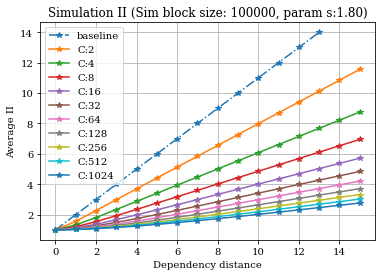

In [8]:
plt.figure()

plt.plot(range(0,L_high-1),range(1,L_high),"*-.", label="baseline")
dep_distance = [i for i in range(0,L_high+1)]
for c,C in enumerate(C_list):
  curve = Simulation_IIs[c]
  plt.plot(dep_distance,curve,"*-",label="C:%d"%C)

plt.legend()
plt.title("Simulation II (Sim block size: %d, param s:%4.2f)" % (SIZE_OF_SIM_BLOCK,s))
plt.xlabel("Dependency distance")
plt.ylabel("Average II")
plt.grid()

## $\overline{II}_{sys}$  approximation

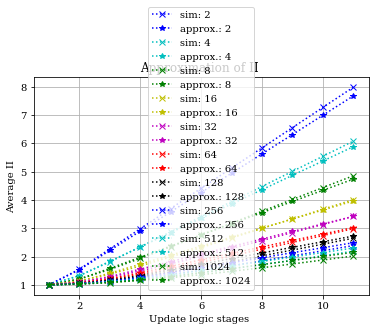

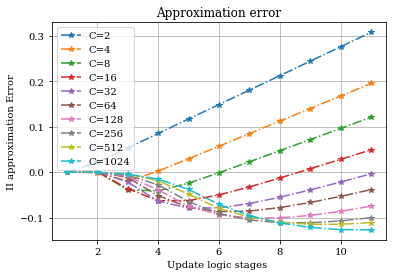

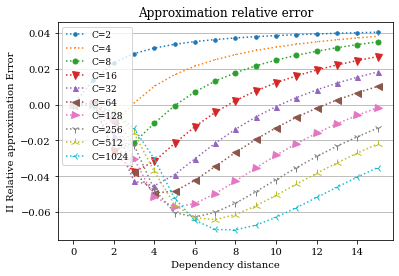

In [9]:
def approx_II(L,Pc):
  ''' get exact value or approximation of II'''
  first_approx = lambda L,Pc :1 + (L*L + L)*Pc/2
  II_lim = 1.35
  L_lim = -.5 + .5*np.sqrt(8*(II_lim-1)/Pc+1)
  if L <= L_lim:
    return first_approx(L,Pc)
  else:
    b = (2*L_lim+1)*Pc/2
    return II_lim + b*(L-L_lim )

# Approx
plt.figure()
plt.title("Approximation of II ")
plt.xlabel("Update logic stages ")
plt.ylabel("Average II")
plt.grid()
L_high = 10
s=sim_s

clr_idx = 1-len(colors)
for C_idx in range(C_idx_high):
  C = 2**(C_idx+1)
  max_L = L_high
  curve = Simulation_IIs[C_idx,:max_L+1]
  L_axis = range(0,max_L+1)
  Stages = [l+1 for l in L_axis]
  Pc = sum( zipf_prob(k,s,N=C)**2 for k in range(1,C+1))
  curve_approx = [ approx_II(l,Pc) for l in L_axis]
  plt.plot(Stages,curve,"x:",color=colors[clr_idx],label="sim: %d"%C)
  plt.plot(Stages,curve_approx,"*:",color=colors[clr_idx],label="approx.: %d"%C)
  clr_idx +=1
plt.legend()


# Error plot
plt.figure()
plt.title("Approximation error")
plt.xlabel("Update logic stages ")
plt.ylabel("II approximation Error")
plt.grid()

for C_idx in range(C_idx_high):
  C = 2**(C_idx+1)
  max_L = L_high
  curve = Simulation_IIs[C_idx,:max_L+1]
  L_axis = range(0,max_L+1)
  Stages = [l+1 for l in L_axis]
  Pc = sum( zipf_prob(k,s,N=C)**2 for k in range(1,C+1))
  curve_approx = [ approx_II(l,Pc) for l in L_axis]
  diff = [a-b for a,b in zip(curve,curve_approx)]
  plt.plot(Stages,diff,"*-.",label="C=%d"%C)
plt.legend()
  
#relative Error plot
fig = plt.figure()
plt.title("Approximation relative error")
plt.xlabel("Dependency distance")
plt.ylabel("II Relative approximation Error")
plt.grid(True,axis='y')
marker_idx=0
L_high = 15
for C_idx in range(C_idx_high):
  C = 2**(C_idx+1)
  max_L = L_high
  curve = Simulation_IIs[C_idx,:max_L+1]
  L_axis = range(0,max_L+1)
  Stages = [l+1 for l in L_axis]
  Pc = sum( zipf_prob(k,s,N=C)**2 for k in range(1,C+1))
  curve_approx = [ approx_II(l,Pc) for l in L_axis]
  diff = [(a-b)/a for a,b in zip(curve,curve_approx)]
  markersize = 5 if markers[marker_idx] in ['o', '^','d','s'] else (9 if markers[marker_idx]=='2' else 7)
  plt.plot(L_axis,diff,markers[marker_idx]+":",markersize=markersize,label="C=%d"%C)
  marker_idx +=1
  
plt.legend(prop={'size': 9},loc='upper left')

# $\overline{II}_{sys}$ Distribution

### Simulation for different cards and Latencies

In [10]:
s=1.8
C_idx_high = 10
C_list= [2**i for i in range(1,C_idx_high+1)] # id range size  
L_high = 10
nthr=6
window_size=1000
SIZE_OF_SIM_BLOCK = 1000000
Simulation_II_time_series = []
DD_axis = range(0,L_high+1)
for C in tqdm(C_list):
  CDF = zipf_CDF(s,C)
  
  def test_kernel(x):
    return time_series_simulation_stall_stage(x,C,seed=0,window_size = window_size,
                                    num_of_elem = SIZE_OF_SIM_BLOCK,id_generator=lambda : rand_CDF(CDF))

  with Pool(processes=nthr) as p:
    res = p.map(test_kernel,DD_axis)
    Simulation_II_time_series += [res]
  
#   return Simulation_II_time_series

# Simulation_II_time_series =  get_time_series_map()

100%|██████████| 10/10 [03:35<00:00, 21.53s/it]


### $\overline{II}_{sys}$ Density (Violin) plots

100%|██████████| 4/4 [01:22<00:00, 20.53s/it]


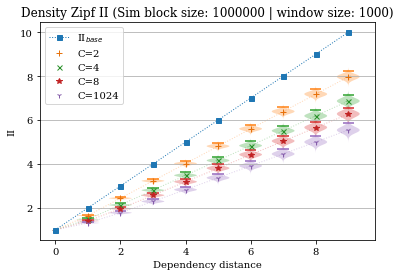

In [11]:
markers = [ '+', 'x', '*', '1', '3', '.','2','4', 's', 'p', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
fig = plt.figure()
plt.plot(range(0,L_high),range(1,L_high+1),"s",linestyle='dotted',markersize=5,zorder=2,linewidth=1.0, label="II$_{base}$")

idx=0
for c in tqdm([0,1,2,9]):
  C = 2**(c+1)
  DD_array = [DD for DD in range(10)]
  data = [ np.array(Simulation_II_time_series[c][DD][1])/window_size for DD in DD_array[1:]]
  quantiles = [[.99] for i in DD_array[1:]]
  violin_parts = plt.violinplot(data, DD_array[1:], points=60, widths=0.7, showmeans=False, 
                            bw_method=0.5,showextrema=False, quantiles=quantiles)
  av_curve = [ Simulation_II_time_series[c][DD][0] for DD in DD_array]
  curve_color = violin_parts['bodies'][0].get_facecolor()[0]
  if 'x'==markers[idx]:
    plt.plot(DD_array[1:],av_curve[1:],markers[idx],markersize=5,color=curve_color[:3]*.9,label="C=%d"%C)
  else:
    plt.plot(DD_array[1:],av_curve[1:],markers[idx],color=curve_color[:3]*.9,label="C=%d"%C)
  plt.plot(DD_array,av_curve,markers[clr_idx],color=curve_color,linestyle='dotted',linewidth=1.0, zorder=1)
  idx+=1
  
plt.legend(prop={'size': 10})
plt.title("Density Zipf II (Sim block size: %d | window size: %d)" % (SIZE_OF_SIM_BLOCK,window_size))
plt.xlabel("Dependency distance")
plt.ylabel("II")
plt.grid(True,axis='y')

## $\overline{II}_{sys}$  distribution

### Approximate distribution solution for L=1

Given W elements, we want to get the probability of processing them in C cycles.
Then, we can get the probability of II as $II= cycles/W$

There are to possible sequencies for L =1:
- $S_0$ : p. 
- $S_1$ : b,p. 

where *p* means that the sample is processed and *b* that a bubble is inserted.


$P(S_1)$ is set to $\overline{Pc} = \sum^{a \in A} P(a)^2$, where $A$ is the symbol set

Then, the number of S_1 in the window, $x$:

$x \sim B\binom{n=W}{p = Pc}$

This is translated to cycles as: $cycles = (W -x) + x*2 $.




In [12]:
L=1
s=1
cardinality = 64
window_size = 200
num_of_elem = 50000
CDF = zipf_CDF(s,cardinality)
II_sim, cycle_count_series = time_series_simulation_stall_stage(L,cardinality,seed=1,window_size = window_size,
                                                      num_of_elem = num_of_elem,id_generator=lambda : rand_CDF(CDF))
print("II_sim:", II_sim)

II_sim: 1.07244


In [13]:
print("II_sim long:",Simulation_IIs[int(np.log2(cardinality))-1,L])
p = sum( zipf_prob(k,s,N=cardinality)**2 for k in range(1,cardinality+1))
print("p: %6.4f | Estim II= %6.4f" %(p,1+p))

II_sim long: 1.07332
p: 0.0724 | Estim II= 1.0724


p: 0.0724 | Estim II= 1.0724


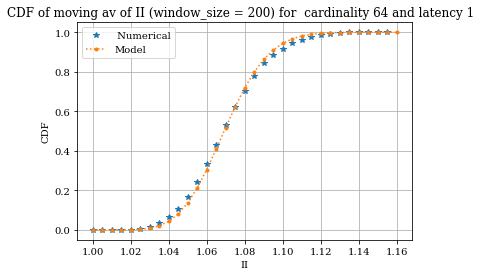

In [14]:
x_axis,CDF= get_II_CDF_from_cycle_series(cycle_count_series,window_size=window_size)

### Plot simulation CDF
plt.figure()
plt.title("CDF of moving av of II (window_size = %d) for  cardinality %d and latency %d  " %(window_size, cardinality, L))
plt.plot(x_axis,CDF,"*",label=" Numerical")
plt.xlabel("II")
plt.ylabel("CDF")

plt.grid(True)



### Plot Model CDF
n = int(window_size)
p = sum( zipf_prob(k,s,N=cardinality)**2 for k in range(1,cardinality+1))
print("p: %6.4f | Estim II= %6.4f" %(p,1+p))
dist = binom(n, p)

x = [i for i in range(n+1)]
CDF = dist.cdf(x)
CDF_II = []
approx_x_axis = []

for cycles,prob in zip(range(n,n*(L+1)+1),CDF):
  CDF_II += [prob]
  approx_x_axis += [cycles/window_size]
  if approx_x_axis[-1]>x_axis[-1]:
    break
  
plt.plot(approx_x_axis,CDF_II,".:",label="Model")
plt.legend()

# Behaviour when incrementing the pipeline depth

Paper figure

In [15]:

def period_estim(Tc,Tpp,s):
  return Tc/s+Tpp if s>1 else Tc

Tc = 8
Tpp = .9
II_update = 1

comb_freq = 1000/Tc # in MHz

latency_axis = [i for i in range(1,11)]

no_opt_rate = []
for update_stages in tqdm(latency_axis):
    period = period_estim(Tc,Tpp,update_stages)
    freq = 1/period*1000/comb_freq # normalized freq
    no_opt_rate += [freq/(update_stages)]

opt_rate = []
C_idx = 0
for cardinality in tqdm( C_list):
  C_idx +=1
  curve = []
  for update_stages in latency_axis:
    period = period_estim(Tc,Tpp,update_stages)
    freq = Tc/period # normalized freq
    II = Simulation_IIs[C_idx-1][update_stages-1]
    curve += [freq/II]
    
  opt_rate += [curve]


100%|██████████| 10/10 [00:00<00:00, 60090.32it/s]


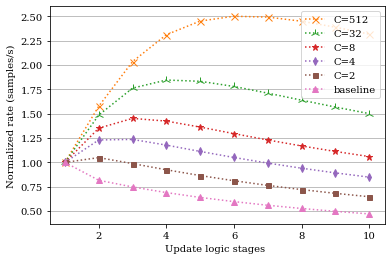

In [16]:
markers = ['o', '^','x','2',  '*', 'd', 's', '.','2','4',  '1', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:olive']
fig = plt.figure()

# feed_forward = [Tc/(period_estim(Tc,Tpp,s)) for s in latency_axis]
# plt.plot(latency_axis,feed_forward,markers[0]+":",label="FF")


max_card_idx = 9
marker_idx = 2
for cardinality in reversed(C_list) :
  C_idx = int(np.log2(cardinality)-1)
  if C_idx in [3,5,6,7,9]:
    continue
  markersize = 5 if markers[marker_idx] in ['o', '^','d','s'] else (9 if markers[marker_idx]=='2' else 7)
  plt.plot(latency_axis,opt_rate[C_idx],markers[marker_idx]+":",color=colors[marker_idx-1],markersize=markersize,label="C=%d" %cardinality)
  marker_idx +=1

plt.plot(latency_axis,no_opt_rate,markers[1]+":",color='tab:pink',label="baseline")

plt.legend(prop={'size': 10},loc='upper right')
plt.xlabel("Update logic stages ")
plt.ylabel("Normalized rate (samples/s)")
plt.grid(True,axis='y')